In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

## Prepare aging data to work with
- We divide the data by the starting value, so the values are R/R_0 relative degredation to initial value
- Then we invert to get to conductances 
- Now we normalize the livetime to $(t_0, t_1) = [0,1]$ from 0 , 37  as t0 and t1

In [3]:
data = pd.read_csv('group2.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data['days'] = data.index
data.days = data.days.diff().dt.days
data.days = data.days.fillna(0).cumsum()
#data.index = pd.to_datetime(data.index)
data.index=data.days
data = data.drop('days', axis=1)
data.head()

,Res_0,Res_1,Res_2,Res_3,Res_4,Res_5
days,,,,,,
0.0,15681.818182,10000.000000,11785.714286,14166.666667,17500.000000,14166.666667
1.0,16730.769231,11785.714286,11785.714286,15681.818182,18776.595745,15681.818182
2.0,17500.000000,12425.373134,12884.615385,17500.000000,19722.222222,16730.769231
3.0,19722.222222,13629.032258,14166.666667,19722.222222,22500.000000,17500.000000
6.0,21309.523810,14166.666667,15681.818182,22500.000000,23815.789474,18776.595745


In [4]:
data = data/data.min() # ratio to initial value
data = 1/data
data.index = data.index/data.index.max()
data.columns = ['Cond_{}'.format(i) for i in range(data.shape[1])]
data

,Cond_0,Cond_1,Cond_2,Cond_3,Cond_4,Cond_5
days,,,,,,
0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.027027,0.937304,0.848485,1.000000,0.903382,0.932011,0.903382
0.054054,0.896104,0.804805,0.914712,0.809524,0.887324,0.846743
0.081081,0.795134,0.733728,0.831933,0.718310,0.777778,0.809524
0.162162,0.735907,0.705882,0.751553,0.629630,0.734807,0.754485
0.243243,0.696970,0.637681,0.751553,0.629630,0.671233,0.718310
0.432432,0.601494,0.604317,0.673469,0.629630,0.619048,0.673660
0.621622,0.545455,0.571429,0.642857,0.543379,0.608696,0.664804
1.000000,0.508600,0.444444,0.523810,0.426523,0.567568,0.629630


# Fit Model

In [5]:
from scipy.optimize import curve_fit
from scipy.special import comb

def get_piecewise_linear(x, *params):
    ''' 
    approximate the aging by two-segment linear function
    '''
    
    m0, m1, b1 = params
    b0 = 1
    
    mod = lambda z : max(z*m0 + b0, z*m1 + b1)

    return np.array([mod(xi) for xi in x])

def get_exponential_function(x, *params):
    '''
    approximate the aging by exponential function
    '''
    a, b = params
    return a * np.exp(b * x) + 1 - a

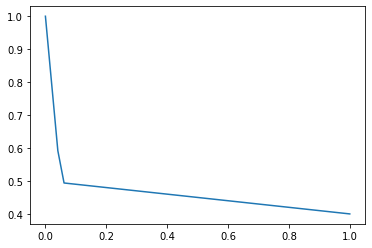

In [6]:
p0 = np.array([-10, -.1, .5])
vals = np.linspace(0,1)
plt.plot(vals, get_piecewise_linear(vals, *p0));

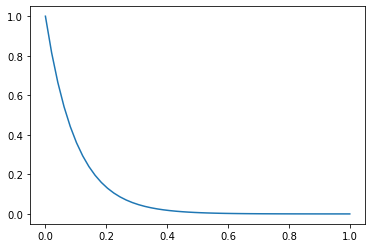

In [7]:
params = [1, -10]
vals = np.linspace(0,1)
plt.plot(vals, get_exponential_function(vals, *params));

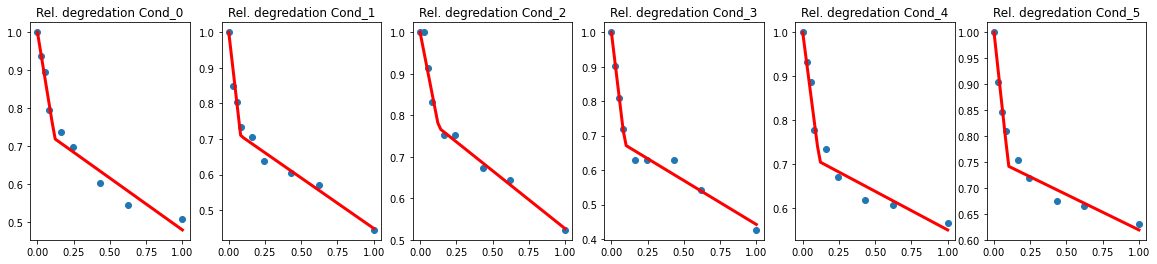

In [8]:
fig, ax = plt.subplots(ncols = len(data.columns), figsize=(20,4))

# bounds and starting value for fitting
p0 = np.array([-10, -.1, .5]) # np.array([-2, -1, -3])  # <--------------------- the more numbers you put there the more params you have !
bnds = [[-np.inf, -np.inf, -np.inf], [0, 0, 1]]
#bnds = list(zip(*[(-np.inf, 0)]*len(p0)))

param_sets_linear = []
for i, c in enumerate(data.columns):
    
    x,y = data.index, data[c]
    ax[i].scatter(data.index, data[c])
    
    re =curve_fit(get_piecewise_linear, xdata=x, ydata=y, p0=p0, maxfev=2000, bounds=bnds)[0]
    ax[i].plot(vals, get_piecewise_linear(vals, *re), c='red', lw=3)
    ax[i].set_title('Rel. degredation '+c)
    p0 = re
    param_sets_linear.append(re)

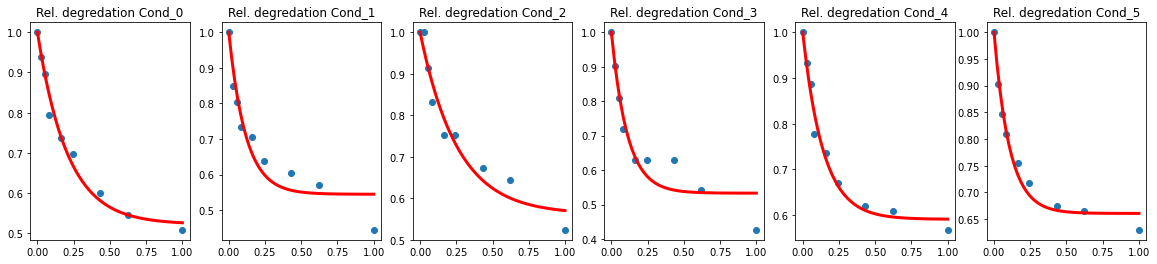

In [9]:
fig, ax = plt.subplots(ncols = len(data.columns), figsize=(20,4))

# bounds and starting value for fitting
p0 = [1, -10]
bnds = [[-np.inf, -np.inf], [np.inf, 0]]

param_sets_exp = []
for i, c in enumerate(data.columns):
    
    x,y = data.index, data[c]
    ax[i].scatter(data.index, data[c])
    
    re =curve_fit(get_exponential_function, xdata=x, ydata=y, p0=p0, maxfev=2000, bounds=bnds)[0]
    ax[i].plot(vals, get_exponential_function(vals, *re), c='red', lw=3)
    ax[i].set_title('Rel. degredation '+c)
    p0 = re
    param_sets_exp.append(re)

# Model the parameter distribution
- Model the param sets with some distribution model, very simple independent sampling for now

In [10]:
param_data_linear_approx = pd.DataFrame(param_sets_linear, columns = ['m0', 'm1', 'b1'])
params_scales = param_data_linear_approx.std()
params_scales[param_data_linear_approx.max(0) < 0.001] = 0.    # what does this do?
param_data_linear_approx

,m0,m1,b1
0,-2.339153,-0.272843,0.751894
1,-3.543337,-0.283429,0.732167
2,-1.783340,-0.278735,0.805756
3,-3.495552,-0.254715,0.697051
4,-2.537163,-0.175123,0.726412
5,-2.575624,-0.136441,0.755292


In [11]:
param_data_exp_approx = pd.DataFrame(param_sets_exp, columns = ['a', 'b'])
params_scales = param_data_exp_approx.std()
params_scales[param_data_exp_approx.max(0) < 0.001] = 0.
param_data_exp_approx

,a,b
0,0.477429,-4.835317
1,0.455294,-8.607223
2,0.438617,-3.886393
3,0.466833,-9.147731
4,0.409194,-7.068652
5,0.339458,-9.422527


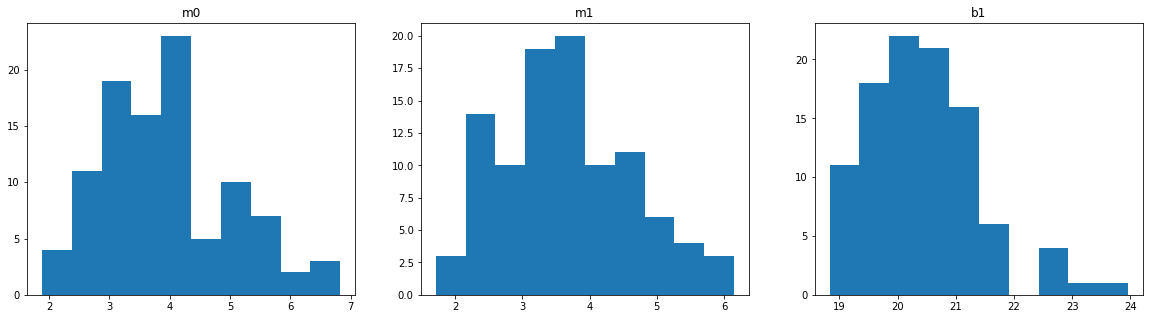

In [12]:
from scipy.stats import norm, chi2, lognorm

# maybe tranform them into a certain range and then invert them ? 

# some positive distribution to model the parameters
base_dist = lognorm # chi2 # lognorm #   <--------------------------------------------- can try different ones here 
dists_linear = {c : base_dist(*base_dist.fit(param_data_linear_approx[c].abs()/param_data_linear_approx[c].std())) for c in param_data_linear_approx.columns}

fig, ax = plt.subplots(1, param_data_linear_approx.shape[1], figsize=(20,5))
for i, c in enumerate(param_data_linear_approx.columns):
    ax[i].hist(dists_linear[c].rvs(100))
    ax[i].set_title(c)

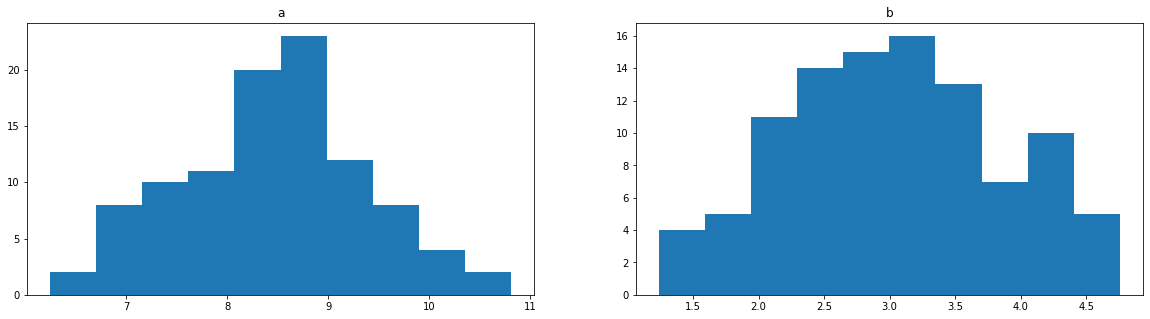

In [13]:
from scipy.stats import norm, chi2, lognorm

# maybe tranform them into a certain range and then invert them ? 

# some positive distribution to model the parameters
base_dist = lognorm # chi2 # lognorm #   <--------------------------------------------- can try different ones here 
dists_exp = {c : base_dist(*base_dist.fit(param_data_exp_approx[c].abs()/param_data_exp_approx[c].std())) for c in param_data_exp_approx.columns}

fig, ax = plt.subplots(1, param_data_exp_approx.shape[1], figsize=(20,5))
for i, c in enumerate(param_data_exp_approx.columns):
    ax[i].hist(dists_exp[c].rvs(100))
    ax[i].set_title(c)

# Draw samples 

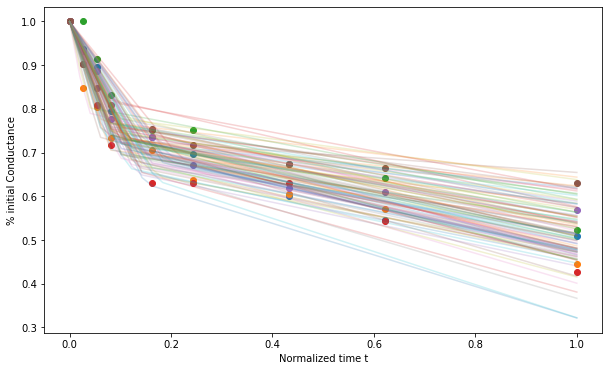

In [14]:
plt.figure(figsize=(10, 6))
plt.xlabel('Normalized time t')
plt.ylabel('% initial Conductance')

def get_param_sample():
    ''' samples from the param distributions '''
    return np.array([dists_linear[c].rvs(1)*param_data_linear_approx[c].std() for c in param_data_linear_approx.columns]).ravel()

def transform_sample(x):
    ''' negates first entries '''
    return np.r_[-x[:-1], x[-1]]

np.random.seed(2)
for i in range(100):
    plt.plot(vals, get_piecewise_linear(vals, *transform_sample(get_param_sample())) , alpha=.2, )

for i, c in enumerate(data.columns):
    x,y = data.index, data[c]
    plt.scatter(data.index, data[c])
    

In [15]:
dists_linear

{'m0': <scipy.stats._distn_infrastructure.rv_frozen at 0x2280e2cd6d0>,
 'm1': <scipy.stats._distn_infrastructure.rv_frozen at 0x2280e2e7dc0>,
 'b1': <scipy.stats._distn_infrastructure.rv_frozen at 0x2280e2d51c0>}

In [16]:
import aging_model_generator as amg
import importlib
importlib.reload(amg)

linear_aging_model_generator = amg.Linear_aging_model_sampler(dists_linear, param_data_linear_approx=param_data_linear_approx)

In [24]:
test = linear_aging_model_generator

In [25]:
test._get_param_sample()

array([3.18561077, 0.24488679, 0.76093273])

In [30]:
tut = test.get_models(10)

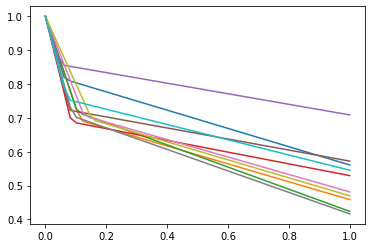

In [31]:
vals = np.linspace(0,1)
for i in range(10):
    plt.plot(vals, tut[i](vals));

In [32]:
import pickle

with open('linear_aging_model.p', 'wb') as f:
    pickle.dump(linear_aging_model_generator, f)

In [33]:

with open('linear_aging_model.p', 'rb') as f:
    ttt = pickle.load(f)

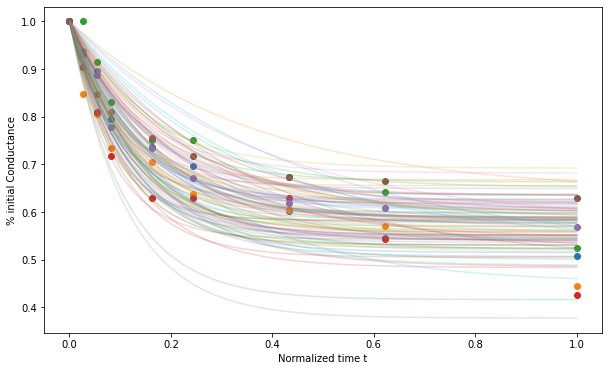

In [14]:
plt.figure(figsize=(10, 6))
plt.xlabel('Normalized time t')
plt.ylabel('% initial Conductance')

def get_param_sample():
    ''' samples from the param distributions '''
    return np.array([dists_exp[c].rvs(1)*param_data_exp_approx[c].std() for c in param_data_exp_approx.columns]).ravel()

def transform_sample(x):
    ''' negates first entries '''
    return np.r_[x[0], -x[1]]

np.random.seed(2)
for i in range(100):
    plt.plot(vals, get_exponential_function(vals, *transform_sample(get_param_sample())) , alpha=.2, )

for i, c in enumerate(data.columns):
    x,y = data.index, data[c]
    plt.scatter(data.index, data[c])
    

# Aging model generator

## Aging aware training

$$ \min_\theta \quad \int_{t=0}^{1} \; L(\theta(t)) \; dt $$
where  $\theta(t)$ is a fitted model of the conductance over time

### MC approximation:

#### Introduction

The goal is to integrate the following formular
$$
\int_t f(t){\rm d}t
$$
Rectangular approximation is 
$$
\sum_n f[n\Delta k]\Delta k
$$
The problem is that, if the sampling rate is lower than twice the frequencce of the function, the error would be large, e.g., integrating a $f(t)=\sin(2\pi (t+\frac{1}{4}))$ with sampling rate $\Delta k=1$, i.e.,
$$
\int_tf(t){\rm d}t\approx\sum_n \sin \left(2\pi (n+\frac{1}{4})\right)=n,
$$
which is obviously wrong.

#### Monte Carlo Approximation

Recall the definition of **Expectation** of a distribution
$$
\begin{align}
\mathbb{E}\{x\}&=\int_x x\cdot p(x) {\rm d}x\\&\approx \frac{1}{N}\sum_{n=1}^N x_n,\ x_n\sim p(x)
\end{align}
$$
Further, 
$$
\begin{align}
\mathbb{E}\{f(x)\}&=\int_x f(x)\cdot p(x) {\rm d}x\\&\approx \frac{1}{N}\sum_{n=1}^N f(x_n),\ x_n\sim p(x)
\end{align}
$$
For a given integration task $\int_x f(x) {\rm d}x$, we can approximate this by
$$
\int_x f(x) {\rm d}x=\int_x f(x)\cdot 1 {\rm d}x=\int_x f(x)\cdot \frac{p(x)}{p(x)} {\rm d}x=\int_x\frac{f(x)}{p(x)}\cdot p(x) {\rm d}x=\mathbb{E}\left\{\frac{f(x)}{p(x)}\right\}\approx\frac{1}{N}\sum_{n=1}^N \frac{f(x_n)}{p(x_n)},\ x_n\sim p(x)
$$
Let $p(x)$ is a uniform distribution, e.g., $p(x)=\frac{1}{b-a},\ x\in[a,b]$, we have
$$
\int_x f(x) {\rm d}x\approx\frac{1}{N}\sum_{n=1}^N \frac{f(x_n)}{p(x_n)}=\frac{b-a}{N}\sum_{n=1}^N f(x_n),\ x\sim p(x).
$$
Let $b=1$ and $a=0$, 
$$
\int_x f(x) {\rm d}x\approx\frac{1}{N}\sum_{n=1}^N f(x_n),\ x\sim p(x),
$$
i.e., we can approximate the integration by averaging the randomly sampled value $f(x)$, with $x$ following uniform distribution.

Moreover, the method in the introduction is a special case of Monte Carlo method.
### Aging Aware Training

The goal of aging aware training is
$$
\min_{\theta_{\rm init}} \int_{t=0}^1 L(\theta(t)){\rm d}t,
$$
where $\theta(t)=\theta_{\rm init}\cdot\mathop{A}(t)$ denotes the aging of the resistors. Using Monto Carlo method, it is converted to
$$
\min_{\theta_{\rm init}} \frac{1}{K}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right),
$$
where $\mathfrak{K}$ is a set of $K$ uniform randomly sampled timestamps $k\in[0,1]$.

To minimize this function, i.e., $\frac{1}{N}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)$, we apply intuitively the gradient descent:
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{K}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{K}\cdot \sum_{k\in \mathfrak{K} } \nabla_{\theta_{\rm init}}\left(L \left(\theta[k]\right)\right)\\
\end{align}
$$

In [15]:
self.theta_
self.time = 

@property
def theta(self):
    return st(self.theta_time)

@property
def theta_time(self):
    return theta * agingmodel(self.t)

SyntaxError: invalid syntax (<ipython-input-15-60246022d1a1>, line 2)

In [16]:
# accumulate gradients for different values of t
net.zero_grad()
for t in ranget:
    net.time = t
    prediction = net(x)
    loss = lossf(prediction, true)
    loss.backward() # accuulation + grad caluclation
    
for p in net.parameters():
    p.grad /= len(ranget)
    
optimizer.step()


NameError: name 'net' is not defined

In [97]:
def aging_generator(N, model, params_approx):
        base_dist = lognorm
        dists_exp = {c : base_dist(*base_dist.fit(params_approx[c].abs()/params_approx[c].std())) for c in params_approx.columns}
        parameter = torch.tensor([dists_exp[c].rvs(N)*params_approx[c].std() for c in params_approx.columns]).T
        if model == 'exp':
            parameter[:, 1] = - parameter[:, 1]
        elif model == 'linear':
            parameter[:, :-1] = - parameter[:, :-1]
        return parameter
p = aging_generator(20, 'linear', param_data_linear_approx)
p

tensor([[-1.5120, -0.2395,  0.7797],
        [-2.2709, -0.0976,  0.7709],
        [-3.2226, -0.2050,  0.7215],
        [-2.7599, -0.2192,  0.7376],
        [-3.3043, -0.1807,  0.7333],
        [-2.4558, -0.2757,  0.7728],
        [-2.7158, -0.3695,  0.7350],
        [-3.1908, -0.1841,  0.7093],
        [-3.1171, -0.1847,  0.7299],
        [-2.9169, -0.3336,  0.7390],
        [-3.4029, -0.2658,  0.7739],
        [-3.5872, -0.2159,  0.7893],
        [-3.6293, -0.1612,  0.7899],
        [-1.7538, -0.2755,  0.7528],
        [-2.3732, -0.2460,  0.7249],
        [-2.4656, -0.3222,  0.7607],
        [-2.4443, -0.1844,  0.7345],
        [-1.7607, -0.2240,  0.7219],
        [-3.5612, -0.2164,  0.7502],
        [-2.0861, -0.2215,  0.7541]], dtype=torch.float64)

In [98]:
theta = torch.rand([5, 2 + 2])
theta
s = theta.shape

In [99]:
theta_temp = theta.clone()
theta_temp = theta_temp.view(-1)
theta_temp

tensor([0.8292, 0.7912, 0.1799, 0.9500, 0.2490, 0.5169, 0.4874, 0.5296, 0.1866,
        0.4670, 0.7931, 0.9817, 0.4935, 0.5096, 0.3634, 0.6637, 0.7355, 0.8119,
        0.6807, 0.1271])

In [103]:
z = 1
aging_decay = torch.max(z * p[:,0] + 1, z * p[:,1] + p[:,2])

aging_decay

tensor([0.5402, 0.6733, 0.5165, 0.5184, 0.5526, 0.4971, 0.3655, 0.5251, 0.5452,
        0.4054, 0.5081, 0.5734, 0.6287, 0.4773, 0.4790, 0.4385, 0.5501, 0.4980,
        0.5339, 0.5326], dtype=torch.float64)

In [94]:
theta_temp *= aging_decay
theta_temp

tensor([0.3949, 0.0667, 0.1820, 0.0101, 0.3516, 0.3597, 0.3432, 0.2040, 0.4200,
        0.4418, 0.5656, 0.4037, 0.5171, 0.3392, 0.2176, 0.2051, 0.2663, 0.2543,
        0.1477, 0.0616])

In [90]:
theta_return = theta_temp.view(s)
theta_return

tensor([[0.3949, 0.0667, 0.1820, 0.0101],
        [0.3516, 0.3597, 0.3432, 0.2040],
        [0.4200, 0.4418, 0.5656, 0.4037],
        [0.5171, 0.3392, 0.2176, 0.2051],
        [0.2663, 0.2543, 0.1477, 0.0616]])

In [91]:
theta

tensor([[0.7082, 0.1111, 0.3145, 0.0153],
        [0.6650, 0.4756, 0.6140, 0.3656],
        [0.6867, 0.7596, 0.9116, 0.7087],
        [0.9085, 0.6291, 0.4044, 0.3402],
        [0.4403, 0.4228, 0.2400, 0.0932]])